In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers     
import numpy as np

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
#load our data into tensorflow dataset
dt=tf.keras.utils.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size =BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dt.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dt)

68

In [27]:
for images_batch,label_batch in dt.take(1):
    print(images_batch[0])
    print(label_batch.numpy())

tf.Tensor(
[[[136. 133. 144.]
  [159. 156. 167.]
  [123. 120. 131.]
  ...
  [154. 152. 163.]
  [149. 147. 158.]
  [142. 140. 151.]]

 [[ 97.  94. 105.]
  [120. 117. 128.]
  [ 96.  93. 104.]
  ...
  [151. 149. 160.]
  [151. 149. 160.]
  [147. 145. 156.]]

 [[163. 160. 171.]
  [116. 113. 124.]
  [117. 114. 125.]
  ...
  [151. 149. 160.]
  [150. 148. 159.]
  [146. 144. 155.]]

 ...

 [[124. 122. 135.]
  [130. 128. 141.]
  [119. 117. 130.]
  ...
  [161. 165. 177.]
  [164. 168. 180.]
  [165. 169. 181.]]

 [[112. 110. 123.]
  [137. 135. 148.]
  [122. 120. 133.]
  ...
  [166. 170. 182.]
  [166. 170. 182.]
  [164. 168. 180.]]

 [[120. 118. 131.]
  [140. 138. 151.]
  [115. 113. 126.]
  ...
  [159. 163. 175.]
  [155. 159. 171.]
  [151. 155. 167.]]], shape=(256, 256, 3), dtype=float32)
[0 0 1 1 1 0 1 0 0 2 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1]


tf.Tensor(
[[[152. 140. 144.]
  [150. 138. 142.]
  [150. 138. 142.]
  ...
  [169. 158. 162.]
  [170. 159. 163.]
  [170. 159. 163.]]

 [[153. 141. 145.]
  [150. 138. 142.]
  [148. 136. 140.]
  ...
  [169. 158. 162.]
  [169. 158. 162.]
  [169. 158. 162.]]

 [[157. 145. 149.]
  [153. 141. 145.]
  [150. 138. 142.]
  ...
  [169. 158. 162.]
  [168. 157. 161.]
  [168. 157. 161.]]

 ...

 [[ 31.  28.  37.]
  [ 34.  33.  41.]
  [ 35.  32.  41.]
  ...
  [167. 156. 160.]
  [163. 152. 156.]
  [163. 152. 156.]]

 [[ 30.  28.  39.]
  [ 34.  34.  44.]
  [ 37.  35.  46.]
  ...
  [182. 171. 175.]
  [180. 169. 173.]
  [165. 154. 158.]]

 [[ 29.  29.  39.]
  [ 35.  35.  45.]
  [ 37.  37.  47.]
  ...
  [191. 180. 184.]
  [185. 174. 178.]
  [155. 144. 148.]]], shape=(256, 256, 3), dtype=float32)
[1 1 2 1 0 0 1 0 2 1 0 0 1 1 2 1 1 2 0 0 0 0 1 0 0 2 0 1 0 1 1 1]


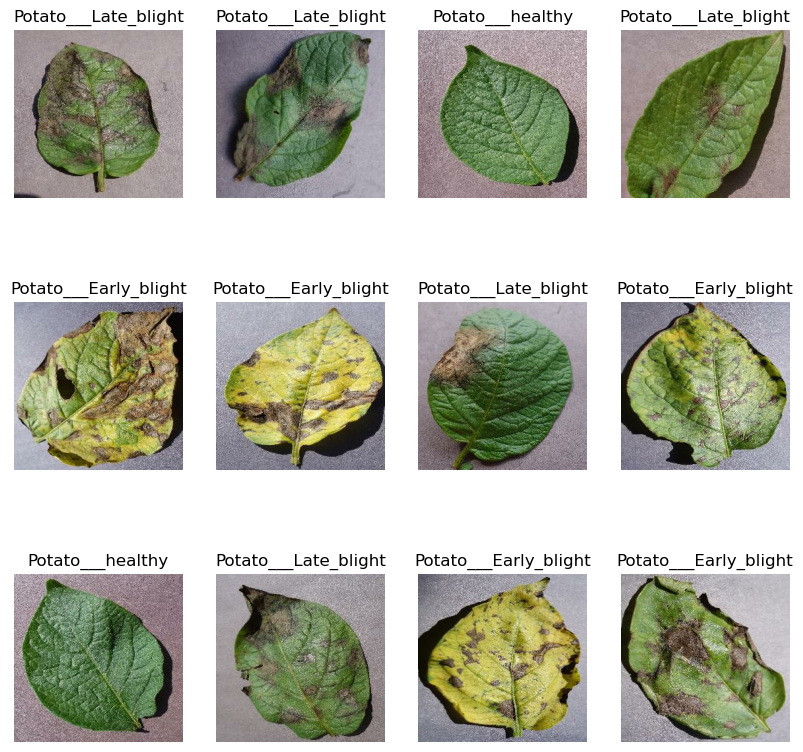

In [8]:
plt.figure(figsize=(10,10))
for images_batch,label_batch in dt.take(1):
    print(images_batch[0])
    print(label_batch.numpy())
    for i in range (12):
        plt.subplot(3,4,i+1)

        ax = plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

    
    

In [9]:
#train set ==>80%
#validation ==>10, test ==>10


In [45]:
def split(dataset,trainsetPer):
    train_ds=dt.take(int(len(dt)*trainsetPer))
    test_ds=dt.skip(len(train_ds))
    val_ds=test_ds.take(int(len(test_ds)*0.5))
    test_ds=test_ds.skip(len(val_ds))
    return train_ds,val_ds,test_ds
split(dt,0.8)

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [46]:
train_ds,val_ds,test_ds=split(dt,0.8)

In [47]:
print(len(train_ds),len(val_ds),len(test_ds))

54 7 7


In [48]:
# enhance the performance with cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [51]:
 #scale images between 0 and 255 and resizing for the prediction 
scale_and_resize=tf.keras.Sequential([
          layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
          layers.experimental.preprocessing.Rescaling(1/255)
 ])

In [52]:
#data augmentation to generate new training samples
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomFlip("vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [53]:
n_classes=3
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model =models.Sequential([
    
    scale_and_resize,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),  
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
    
    
]

)

model.build(input_shape=input_shape)


In [54]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [76]:
from tensorflow.keras.callbacks import EarlyStopping
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='accuracy',     # Monitor validation loss
    patience=5,             # Stop training after no improvement for 5 epochs
    restore_best_weights=True  # Restore best model weights when stopping
)


In [77]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


In [78]:
history = model.fit(
    train_ds,                # Target data (labels).
    batch_size=BATCH_SIZE,         # Number of samples per gradient update.
    epochs=20,                # Number of training epochs.
    verbose=1,               # Verbosity mode (0, 1, or 2).
        # Fraction of data to use for validation.
    validation_data=val_ds,    # Data on which to evaluate loss and any model metrics.
     callbacks=[early_stopping]
   )


Epoch 1/20
54/54 [==============================] - 160s 3s/step - loss: 0.0773 - accuracy: 0.9769 - val_loss: 0.1070 - val_accuracy: 0.9464
Epoch 2/20
54/54 [==============================] - 162s 3s/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.1537 - val_accuracy: 0.9554
Epoch 3/20
54/54 [==============================] - 133s 2s/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.0815 - val_accuracy: 0.9866
Epoch 4/20
54/54 [==============================] - 150s 3s/step - loss: 0.0443 - accuracy: 0.9873 - val_loss: 0.0399 - val_accuracy: 0.9777
Epoch 5/20
54/54 [==============================] - 169s 3s/step - loss: 0.0302 - accuracy: 0.9890 - val_loss: 0.1300 - val_accuracy: 0.9598
Epoch 6/20
54/54 [==============================] - 140s 3s/step - loss: 0.0492 - accuracy: 0.9803 - val_loss: 0.0907 - val_accuracy: 0.9688
Epoch 7/20
54/54 [==============================] - 132s 2s/step - loss: 0.0332 - accuracy: 0.9884 - val_loss: 0.1064 - val_accuracy: 0.9643
Epoch 8/20
54

In [80]:
scores=model.evaluate(test_ds)

7/7 [==============================] - 4s 579ms/step - loss: 0.0547 - accuracy: 0.9800


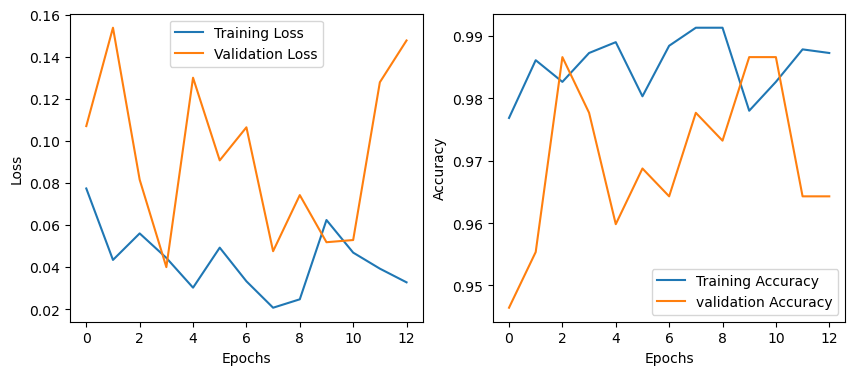

In [81]:
import matplotlib.pyplot as plt

# Access loss and metrics history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
# Plot loss and accuracy curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


first image to predict
actual label Potato___Early_blight
1/1 [==============================] - 1s 542ms/step
(32, 3)
Potato___Early_blight


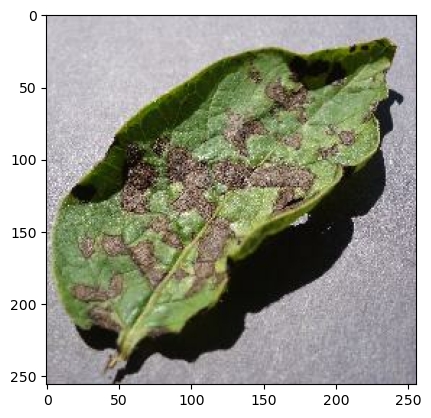

In [89]:
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[3].numpy().astype('uint8')
    first_label= labels_batch[3].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print('actual label',class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print(batch_prediction.shape)
    print(class_names[np.argmax(batch_prediction[3])])

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

(32, 256, 256, 3)
1/1 [==============================] - 0s 42ms/step


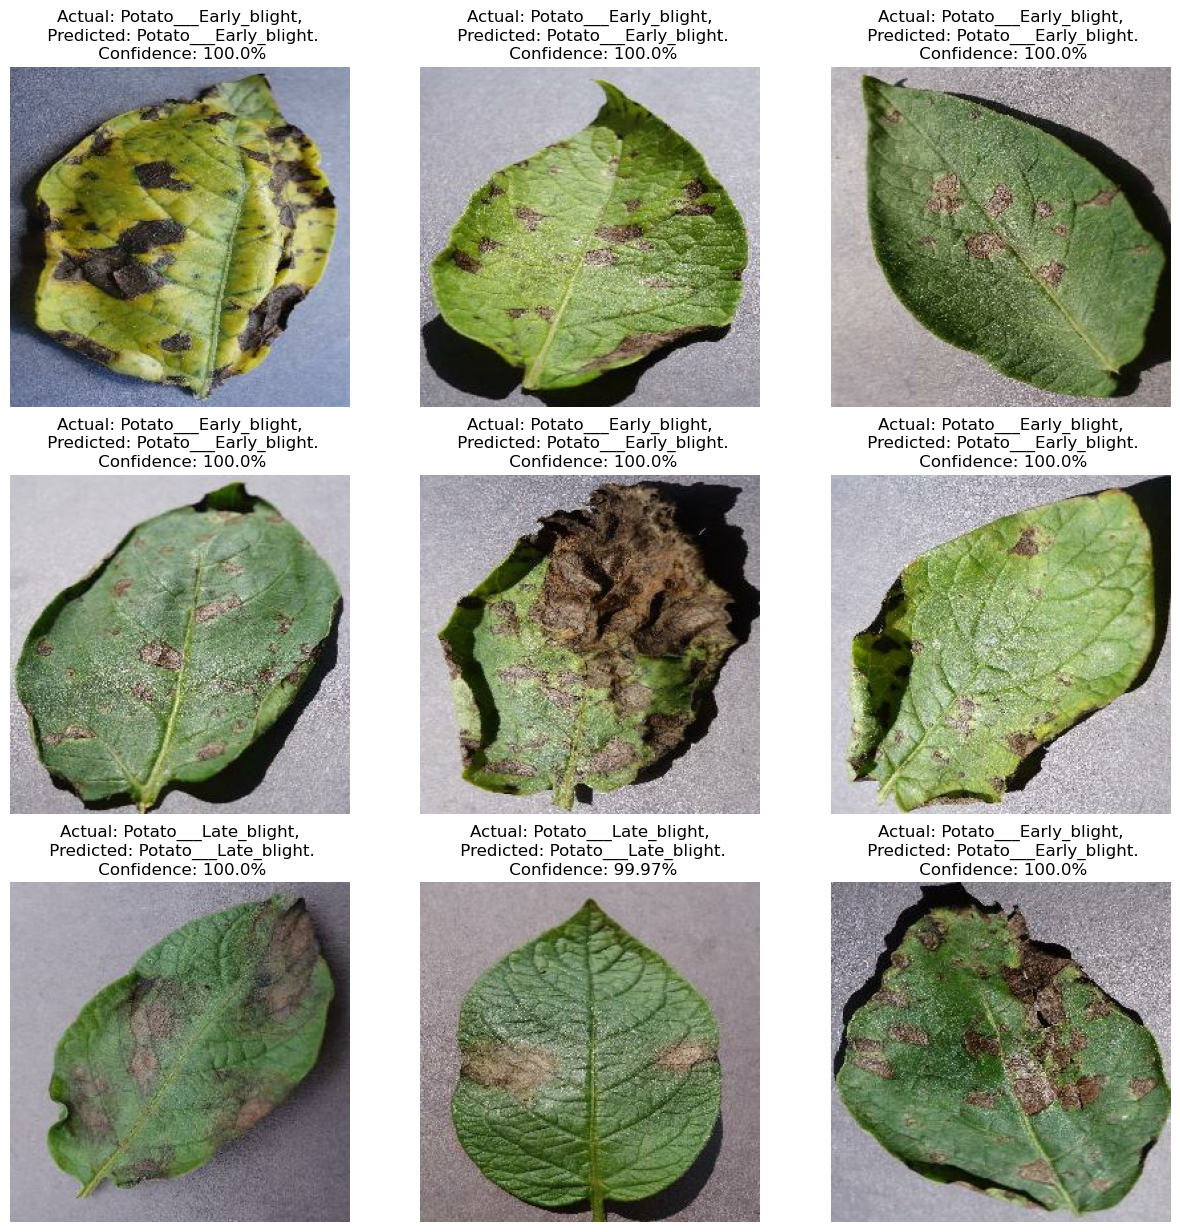

In [86]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    print(images.shape)


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [90]:
model_version=1
model.save(f'../model/{model_version}')

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets
